<a href="https://colab.research.google.com/github/hwanhuh/LG_AI_Lab/blob/main/Image_Editing_with_StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>1. Install CLIP</b>

* CLIP jointly trains an image encoder and a text encoder using a large dataset.
* The cosine similarity between an image and text feature is high if they have similar semantic meanings.

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3a7gxd73
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-3a7gxd73


#### <b>2. Load the Pre-trained StyleGAN Model</b>

* StyleGAN is an efficient architecture to generate high-quality images.

In [2]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

fatal: destination path 'StyleCLIP-Tutorial' already exists and is not an empty directory.
/content/StyleCLIP-Tutorial


In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-01-04 05:13:59--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt [following]
--2022-01-04 05:14:01--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  38.7MB/s    in 15s     

2022-01-04 05:14:17 (23.5 MB/s) - ‘

In [4]:
import torch
import numpy as np
from stylegan2.model import Generator
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

# stylegan 을 이용하여 랜덤한 얼굴 이미지 생성 
def make_new_face():
  g_ema = Generator(1024, 512, 8)
  g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
  g_ema.eval()
  return g_ema.cuda()

In [5]:
# 생성한 이미지 확인해보기 
import matplotlib.pyplot as plt

def show_face(g_ema):
  mean_latent = g_ema.mean_latent(4096)
  latent_code_init_not_trunc = torch.randn(1, 512).cuda()
  with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True, truncation=0.7, truncation_latent=mean_latent)

  # Visualize a random latent vector.
  image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
  return image, latent_code_init

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


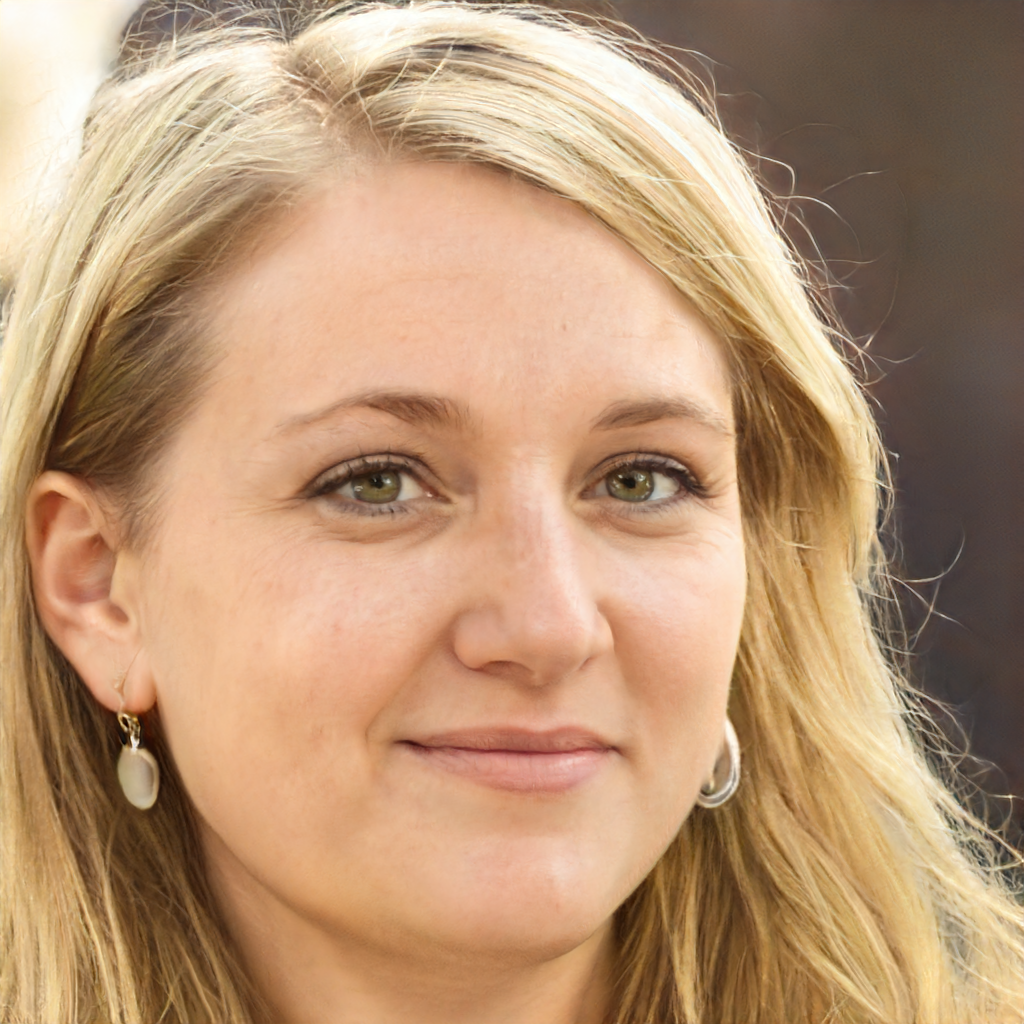

In [6]:
g_ema = make_new_face()
image, latent_code_init = show_face(g_ema)

h, w = image.size
image.resize((h // 4, w // 4))
image

#### <b>3. CLIP Loss</b>

In [7]:
import clip

# clip 의 encoder 를 통해 cos similarity loss 를 설정
class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

#### <b>4. Latent Optimization</b>

* The basic idea is as follows:

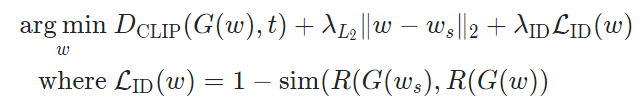

* Initialize a random latent vector using a mean latent vector.

* The optimization method updates the $w$ vector.
* In this source code, we use only $D_{CLIP}(G(w),t) + \lambda_{L2} ||w-w_s||_2$.

* Set parameters for a practice.

In [29]:
# hyperparameter 설정하기 

from argparse import Namespace

args = Namespace()
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 50
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [30]:
import os
import math
import torchvision
from torch import optim


# learning rate 조정 함수 
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

In [31]:
# CLIP 을 통해 생성된 이미지 바꿔보기 
from tqdm import tqdm

def change_face(args, description, latent_code_init):
  text_inputs = torch.cat([clip.tokenize(description)]).cuda()
  os.makedirs(args.results_dir, exist_ok=True)

  # latent vector 초기 설정 
  latent = latent_code_init.detach().clone()
  latent.requires_grad = True

  clip_loss = CLIPLoss()
  optimizer = optim.Adam([latent], lr=args.lr)

  for i in tqdm(range(args.step)):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    # print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

  return img_gen

In [44]:
# 만들고 싶은 표정을 써보세요
# e.g., 'A sad face', 'A angry face', 'A happy face', 'A surprised face', 'A face with makeup face', 'A face with mohawk hairstyle', 'A face with grey hair', 'A really beauty face', 'A face with Hi-top fade hair'
description = 'A face with blue eyes'

In [45]:
img_gen = change_face(args, description, latent_code_init)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


#### <b>5. Result Visualization</b>

In [46]:
# 처음 이미지와 생성된 이미지 대조해서 보기
with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


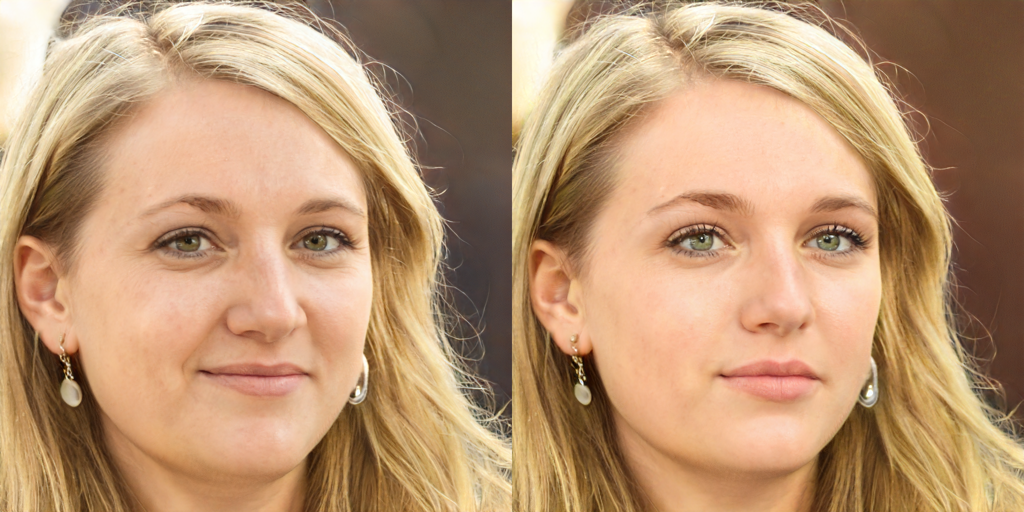

In [47]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [48]:
# 동영상으로 중간 결과물들도 함께보기

!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>